<a href="https://colab.research.google.com/github/AlexsaTasara/RK_Tarasova/blob/master/RK_Tarasova_vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational AutoEncoder

(https://twitter.com/fchollet)<br>
Convolutional Variational AutoEncoder (VAE) trained on MNIST digits.

## Setup


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

## Строим слой семплирования sampling layer


In [2]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## Строим энкодер encoder


In [4]:
latent_dim = 7

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_2 (Conv2D)              (None, 14, 14, 32)   320         ['input_2[0][0]']                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d_2[0][0]']               
                                                                                                  
 flatten_1 (Flatten)            (None, 3136)         0           ['conv2d_3[0][0]']               
                                                                                            

## Строим свой decoder


In [5]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 7)]               0         
                                                                 
 dense_2 (Dense)             (None, 3136)              25088     
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        289 

## Создаем класс модель по `Model` с особым шагом *обучения* `train_step`


In [6]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

## Учим VAE


In [7]:
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=10, batch_size=128)


4422102/4422102 [==============================] - 1s 0us/step
Epoch 1/10
547/547 [==============================] - 15s 12ms/step - loss: 293.3300 - reconstruction_loss: 289.3164 - kl_loss: 4.0136
Epoch 2/10
547/547 [==============================] - 7s 12ms/step - loss: 245.6723 - reconstruction_loss: 241.7260 - kl_loss: 3.9463
Epoch 3/10
547/547 [==============================] - 6s 11ms/step - loss: 239.1991 - reconstruction_loss: 235.3888 - kl_loss: 3.8103
Epoch 4/10
547/547 [==============================] - 5s 9ms/step - loss: 236.5860 - reconstruction_loss: 232.8525 - kl_loss: 3.7335
Epoch 5/10
547/547 [==============================] - 5s 9ms/step - loss: 235.0089 - reconstruction_loss: 231.3245 - kl_loss: 3.6844
Epoch 6/10
547/547 [==============================] - 5s 9ms/step - loss: 233.9013 - reconstruction_loss: 230.2660 - kl_loss: 3.6353
Epoch 7/10
547/547 [==============================] - 5s 9ms/step - loss: 232.9881 - reconstruction_loss: 229.3906 - kl_loss: 3.5975
Ep

In [8]:
vae.fit(mnist_digits, epochs=50, batch_size=128)

Epoch 1/50
547/547 [==============================] - 5s 9ms/step - loss: 230.9397 - reconstruction_loss: 227.4618 - kl_loss: 3.4778
Epoch 2/50
547/547 [==============================] - 5s 9ms/step - loss: 230.6197 - reconstruction_loss: 227.1782 - kl_loss: 3.4415
Epoch 3/50
547/547 [==============================] - 5s 9ms/step - loss: 230.2807 - reconstruction_loss: 226.8765 - kl_loss: 3.4042
Epoch 4/50
547/547 [==============================] - 5s 9ms/step - loss: 229.9431 - reconstruction_loss: 226.5755 - kl_loss: 3.3677
Epoch 5/50
547/547 [==============================] - 5s 9ms/step - loss: 229.7394 - reconstruction_loss: 226.4068 - kl_loss: 3.3326
Epoch 6/50
547/547 [==============================] - 5s 9ms/step - loss: 229.4590 - reconstruction_loss: 226.1471 - kl_loss: 3.3119
Epoch 7/50
547/547 [==============================] - 5s 9ms/step - loss: 229.2619 - reconstruction_loss: 225.9740 - kl_loss: 3.2880
Epoch 8/50
547/547 [==============================] - 5s 9ms/step - l

## Результат предсказания для одежды


In [9]:
def plot_latent(encoder, decoder):
    # display a n*n 2D manifold of digits
    n = 30
    digit_size = 28
    scale = 2.0
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi, 0, 0, 0, 0, 0]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

1/1 [==============================] - 0s 15ms/step


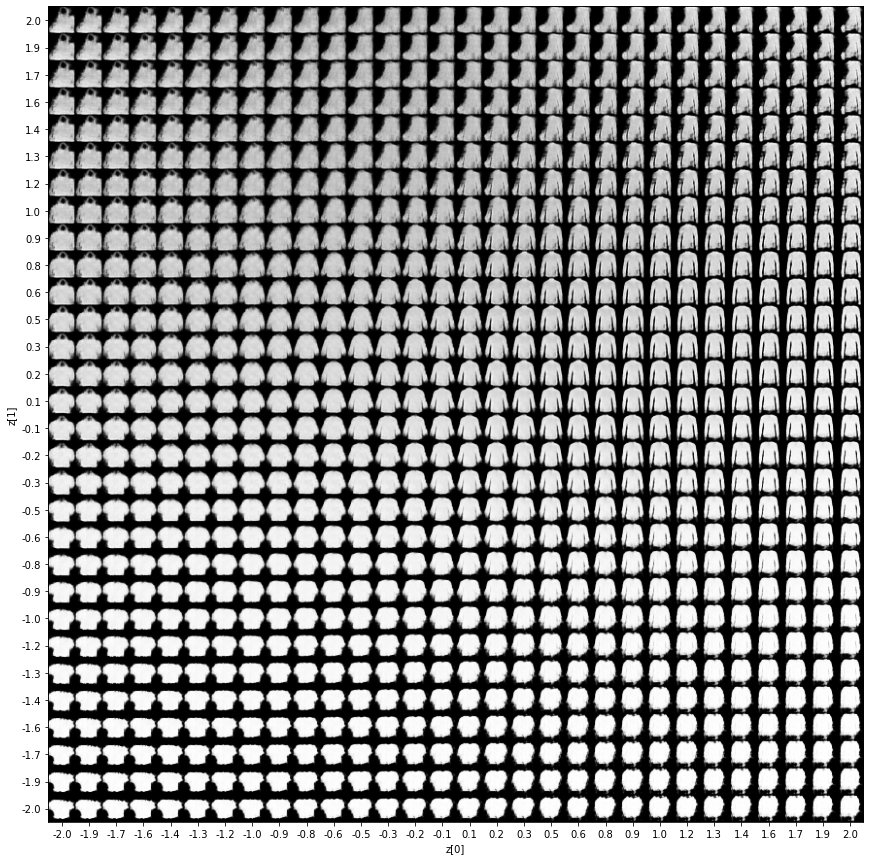

In [10]:
plot_latent(encoder, decoder)

1/1 [==============================] - 0s 130ms/step


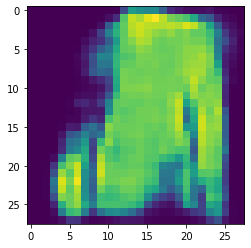

In [12]:
x_decoded = decoder.predict([[1.0,1.5,0,0,0,0,0]])
plt.imshow(x_decoded[0,:,:,0] )
plt.show()

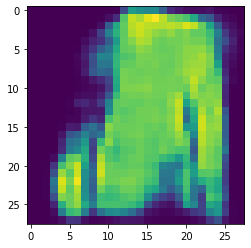

In [13]:
plt.imshow(x_decoded[0,:,:,0] )
plt.show()

## Посмотрим на кластеры в скрытом пространстве для одежды


In [14]:
def plot_label_clusters(encoder, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

1875/1875 [==============================] - 3s 2ms/step


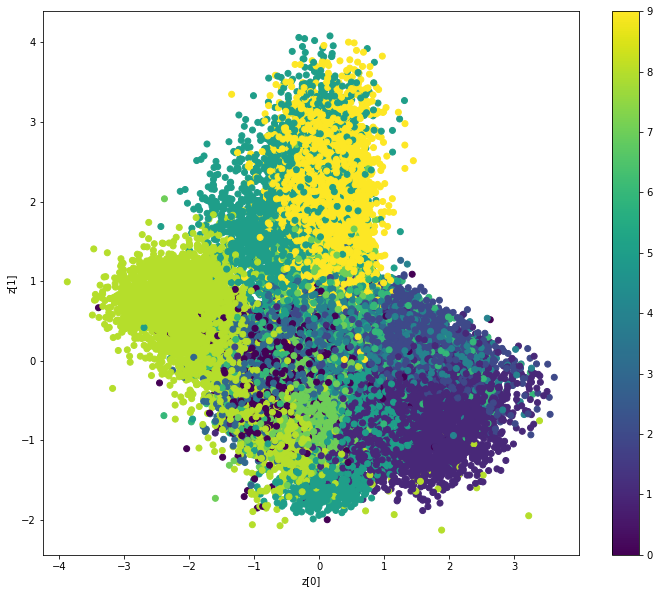

In [15]:
(x_train, y_train), _ = keras.datasets.fashion_mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(encoder, x_train, y_train)

Построим немного примеров генерации одежды:

для этого не нужен энкодер
работа этой модели требует:
- выбрать случайные значения для точки скрытого пространства (2 координаты (среднее и логарифм от дисперсиии) - для построения в n (в нашем случае 28х28) координаты нового образца )
- подать их в декодер
- визуализировать результат

In [26]:
def plot_digit_from_decoder(decoder, z, digit_size):
    # display a 2D plot of the digit classes in the latent space
    
    data = np.array([[z[0], z[1], 0, 0, 0, 0, 0]])
    digit = decoder.predict(data)
    digit = digit.reshape(digit_size, digit_size)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(digit)
    plt.colorbar()
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

1/1 [==============================] - 0s 16ms/step


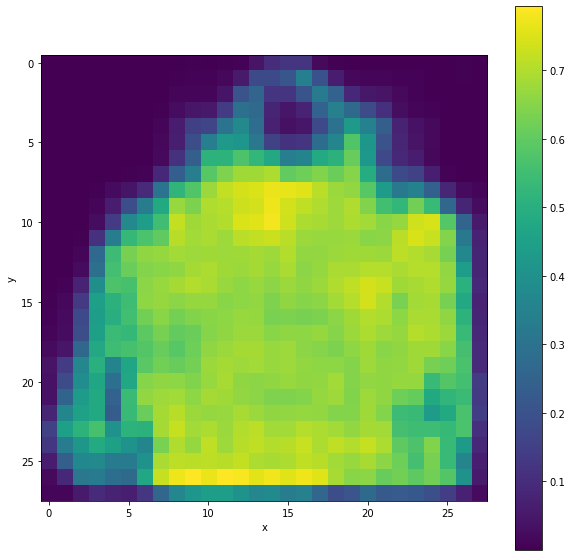

In [27]:
plot_digit_from_decoder(decoder, [-1.5,1.], 28)